## Chapter 10: Nonlinear Learning and Feature Engineering

# 10.1  Features, functions, and nonlinear regression

In this Section we introduce the general framework of nonlinear regression via the engineering of nonlinear feature transformations, along with many examples ranging from toy datasets to classic examples from differential equations.  While this sort of nonlinear feature engineering is only feasible with low dimensional datasets, by walking through these examples we flush out a number important concepts in concrete terms, coding principles, and jargon-terms in a relatively simple environment that will be omnipresent in our discussion of nonlinear learning going forward.

In [2]:
## This code cell will not be shown in the HTML version of this notebook
# imports from custom library
import sys
sys.path.append('../../')
from mlrefined_libraries import math_optimization_library as optlib
from mlrefined_libraries import nonlinear_superlearn_library as nonlib

# demos for this notebook
regress_plotter = nonlib.nonlinear_regression_demos
static_plotter = optlib.static_plotter.Visualizer()
basic_runner = nonlib.basic_runner
datapath = '../../mlrefined_datasets/nonlinear_superlearn_datasets/'

# import autograd functionality to bulid function's properly for optimizers
import autograd.numpy as np

# import timer
from datetime import datetime 
import copy

# this is needed to compensate for %matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib notebook
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

%load_ext autoreload
%autoreload 2

## 10.1.1  Modeling principles of nonlinear regression

We can easily  move from linear to general *nonlinear* regression - in both its principles and implementation - with few obstacles.  We do this by swapping out the linear model used in the construction of our linear regression (introduced in Chapter 5),

\begin{equation}
\text{model}\left(\mathbf{x},\mathbf{w}\right) = w_0 + x_{1}w_1 + \cdots + x_{N}w_N
\end{equation}

or more compactly denoting

\begin{equation}
\mathbf{w}=\begin{bmatrix}
w_{0}\\
w_{1}\\
w_{2}\\
\vdots\\
w_{N}
\end{bmatrix}
\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,
\mathring{\mathbf{x}}_{\,}=\begin{bmatrix}
1 \\
x_{1}\\
x_{2}\\
\vdots\\
x_{N}
\end{bmatrix}
\end{equation}

as

\begin{equation}
\text{model}\left(\mathbf{x},\mathbf{w}\right) = \mathring{\mathbf{x}}_{\,}^T\mathbf{w}^{\,} 
\end{equation}

with a *nonlinear* one.  For example, instead of using a linear model we could use a nonlinear one, involving a single nonlinear function $f$ that can be parameterized or unparameterized (e.g., tanh, a sine wave, etc.,).  In the jargon of machine learning such a nonlinear function $f$ is often called a nonlinear *feature transformation*, since we it transforms our original input features $\mathbf{x}$.  Our corresponding nonlinear model then takes the form

\begin{equation}
\text{model}\left(\mathbf{x},\Omega\right)  = 
w_0^{\,} + f\left(\mathbf{x}\right){w}_{1}^{\,}.
\end{equation}

Here we represent our set of parameters - both those potentially internal parameters of the function $f$ and those weights in the linear combination - via the set $\Omega$.  For example, in the case $f$ is trivially the identity $f\left(x\right) = x$ and our model is linear our parameter set $\Omega$ reduces to the weights of our linear combination.  As we did in the case of *linear regression*, here we could consider the ideal case - where we have knowledge of the best possible weights so that 

\begin{equation}
\text{model}\left(\mathbf{x}_p,\Omega\right) \approx y_p
\end{equation}

and to recover our ideal weights we would follow the same logic we used in deriving our cost functions for linear regression.  For example, we could square the difference between both sides of the above and sum over all the points, giving the Least Squares cost function $
g\left(\mathbf{w}\right) = \frac{1}{P}\sum_{p=1}^{P}\left(\text{model}\left(\mathbf{x}_p,\Omega\right) - y_p\right)^2
$ that - when minimized properly - still minimizes a squared error of our (now nonlinear) model and provides us with our desired weights.

<figure>
<p>
  <img src= '../../mlrefined_images/nonlinear_superlearn_images/nonlinear_regression.png' width="65%" height="65%" alt=""/>
</p>
<figcaption> <strong>Figure 1:</strong> <em> 
Shown here is the prototypical problem of nonlinear regression, which we achieve by injecting nonlinear feature transformations into our model.  As in the linear case here we aim to tune all parameters of our model to minimize an average error, here shown as vertical dashed lines measured from each point to the nonlinear `model`.
</em>
</figcaption>
</figure>

Indeed in general we could create a nonlinear model that is the weighted sum of $B$ nonlinear functions of our input as

\begin{equation}
\text{model}\left(\mathbf{x},\Omega\right) = w_0 + f_1\left(\mathbf{x}\right){w}_{1} +  f_2\left(\mathbf{x}\right){w}_{2} + \cdots + f_B\left(\mathbf{x}\right)w_B
\end{equation}

where $f_1,\,f_2,\,...\,f_B$ are nonlinear parameterized or unparameterized functions - or *feature transformations* - and $w_0$ through $w_B$ (along with any additional weights internal to the nonlinear functions) are represented in the weight set $\Omega$ and must be tuned properly.   Nonetheless the steps we take to formally employ such a model, its ideal weight values, the derivation of a Least Squares cost function, etc., are entirely similar to what we have now seen in the simpler instance of nonlinear regression (which itself does not differ from the steps taken in modeling the linear case).

Finally, note we can write the generic nonlinear model above more compactly using similar notation similar that introduced in Section 5.1 for our linear modeling.  Stacking a $1$ on top of the vector of nonlinear feature transformation as

\begin{equation}
\mathbf{w}=\begin{bmatrix}
w_{0}\\
w_{1}\\
w_{2}\\
\vdots\\
w_{B}
\end{bmatrix}
\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,
\mathring{\mathbf{f}}_{\,}=\begin{bmatrix}
1 \\
f_1\left(\mathbf{x}\right)\\
f_2\left(\mathbf{x}\right)\\
\vdots\\
f_B\left(\mathbf{x}\right)
\end{bmatrix}
\end{equation}

we can then express our generic nonlinear model above equivalently as

\begin{equation}
\text{model}\left(\mathbf{x},\Omega\right) = \mathring{\mathbf{f}}_{\,}^T \mathbf{w}.
\end{equation}

To denote our vector of feature transformations of a particular training point $\mathbf{x}_p$ we can also write

\begin{equation}
\mathring{\mathbf{f}}_{p}=\begin{bmatrix}
1 \\
f_1\left(\mathbf{x}_p\right)\\
f_2\left(\mathbf{x}_p\right)\\
\vdots\\
f_B\left(\mathbf{x}_p\right).
\end{bmatrix}
\end{equation}

To then compactly express our ideal desire that the parameters $\Omega$ of this set of feature transformations are tuned properly so that our model accurately transforms the input point $\mathbf{x}_p$ to represent its corresponding output value $y_p$ we may write 

\begin{equation}
\text{model}\left(\mathbf{x}_p,\Omega\right) = \mathring{\mathbf{f}}_{p}^T \mathbf{w} \approx y_p.
\end{equation}

For some low-dimensional problems we can fairly easily engineer a proper set of nonlinear features for regression classification 'by eye', that is by examining a dataset visually.  

#### <span style="color:#a50e3e;">Example 1. </span> The linear case

Let us first examine our original linear regression throug the lense of nonlinear feature engineering.   The figure below we shows a low dimensional regression dataset that looks is a clear candidate linear modeling.

<IPython.core.display.Javascript object>


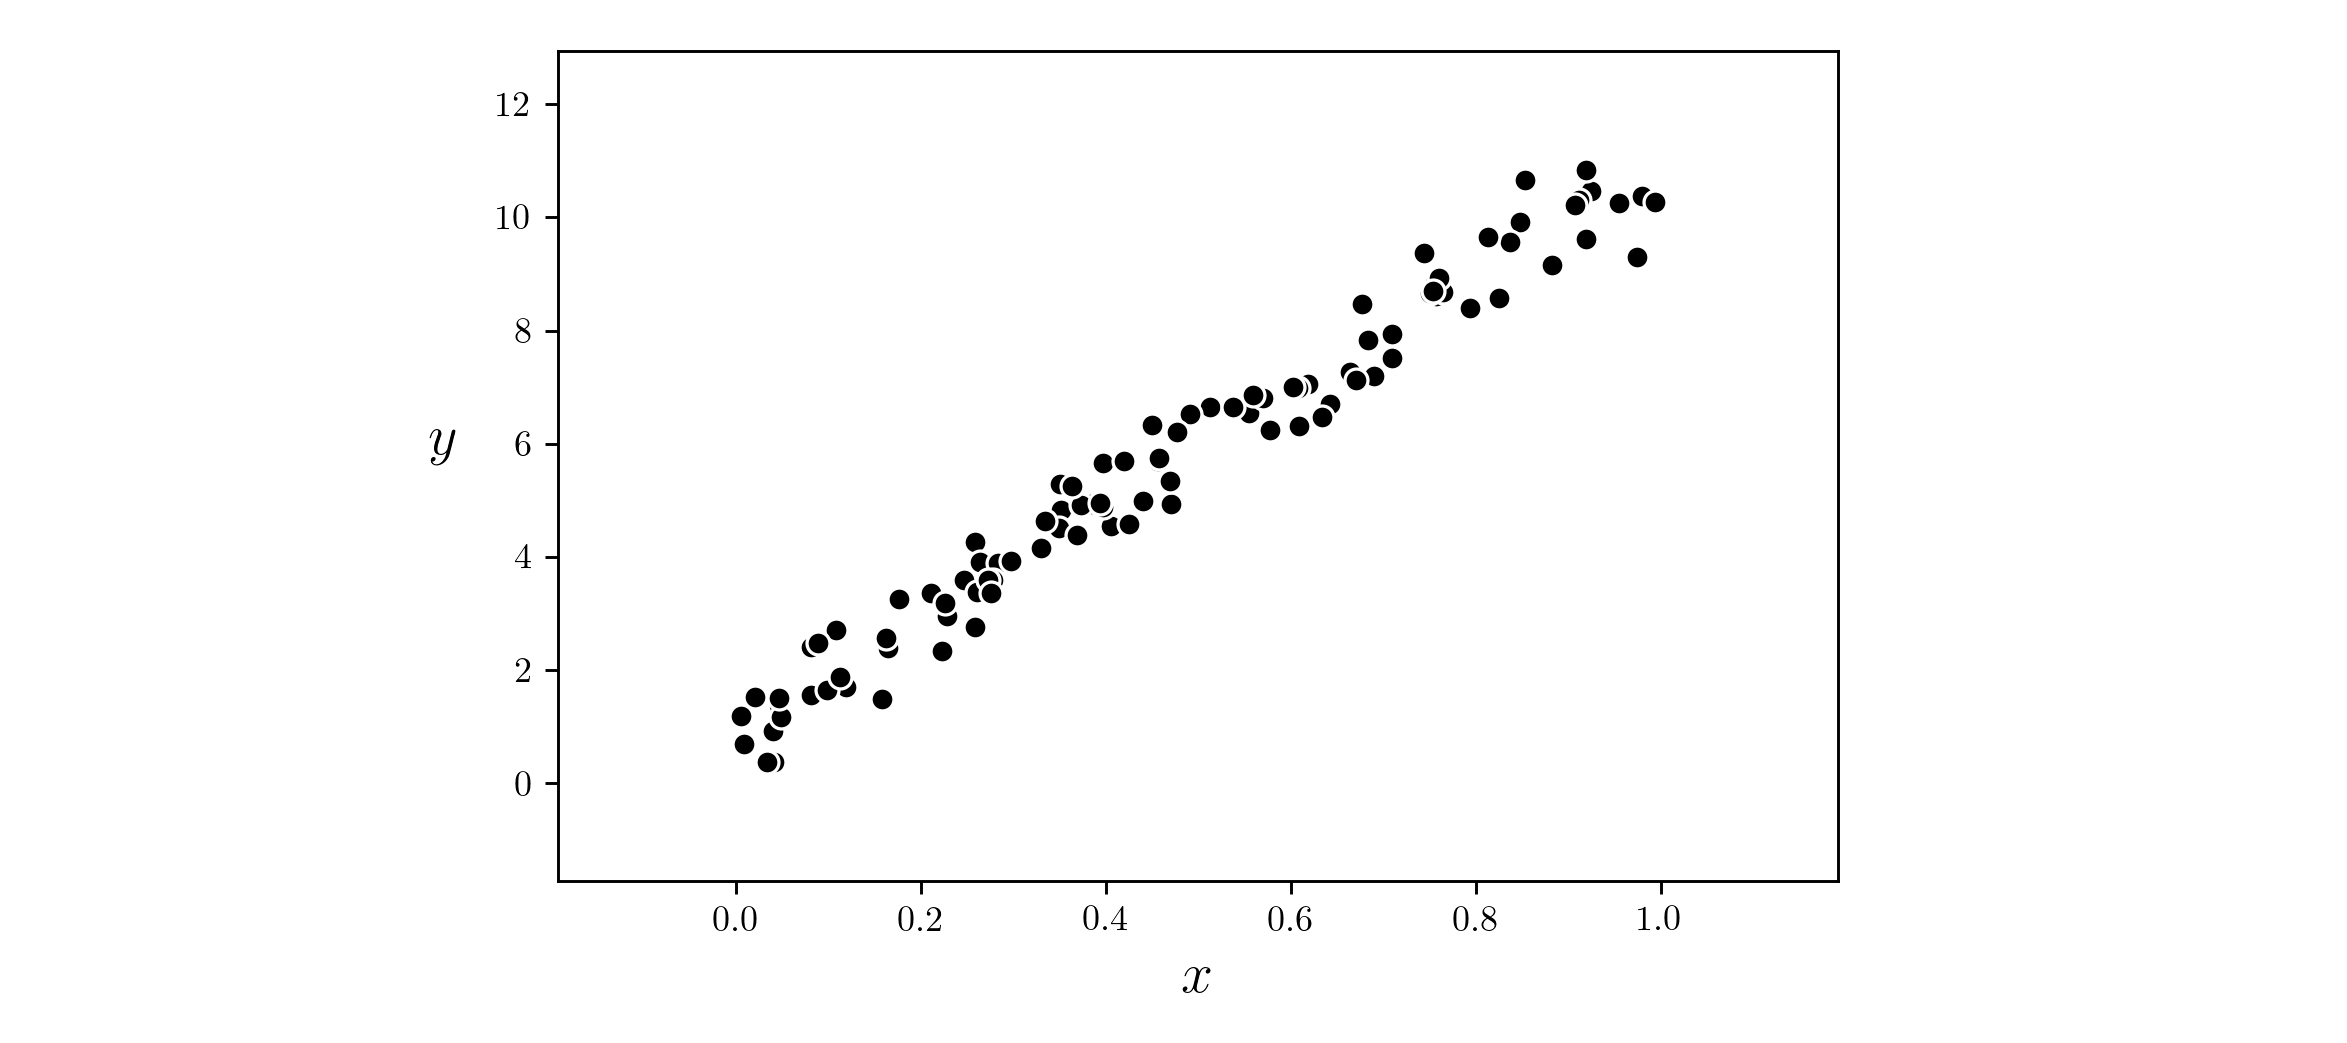

In [3]:
## This code cell will not be shown in the HTML version of this notebook
# load data
data = np.loadtxt(datapath + 'unnorm_linregress_data.csv',delimiter = ',')

# load input/output data
x = data[:-1,:]
y = data[-1:,:] 

# plot dataset
demo = regress_plotter.Visualizer(data)
demo.plot_data()

Since this data looks quite linear in nature, we would clearly employ a linear model.  In terms of feature engineering, here we employ the simple linear feature transformation

\begin{equation}
f\left(x\right) = x
\end{equation}

and in this notation our linear model is then

\begin{equation}
\text{model}\left(x,\Omega\right) = w_0 +f\left(x\right)w_{1\,}.
\end{equation}

Note how in performing standard normalization (subtracing the mean and dividing off the standard deviation of the input) we can actually think of the normalization as being a part of the feature transformation itself, and write it formally as

\begin{equation}
f\left(x \right) = \frac{x - \mu}{\sigma}
\end{equation}

where $\mu$ and $\sigma$ are the mean and standard deviation of the dataset's input. 

Below we plot the fit provided by minimizing the Least Squares cost employing this feature transformation.

<IPython.core.display.Javascript object>


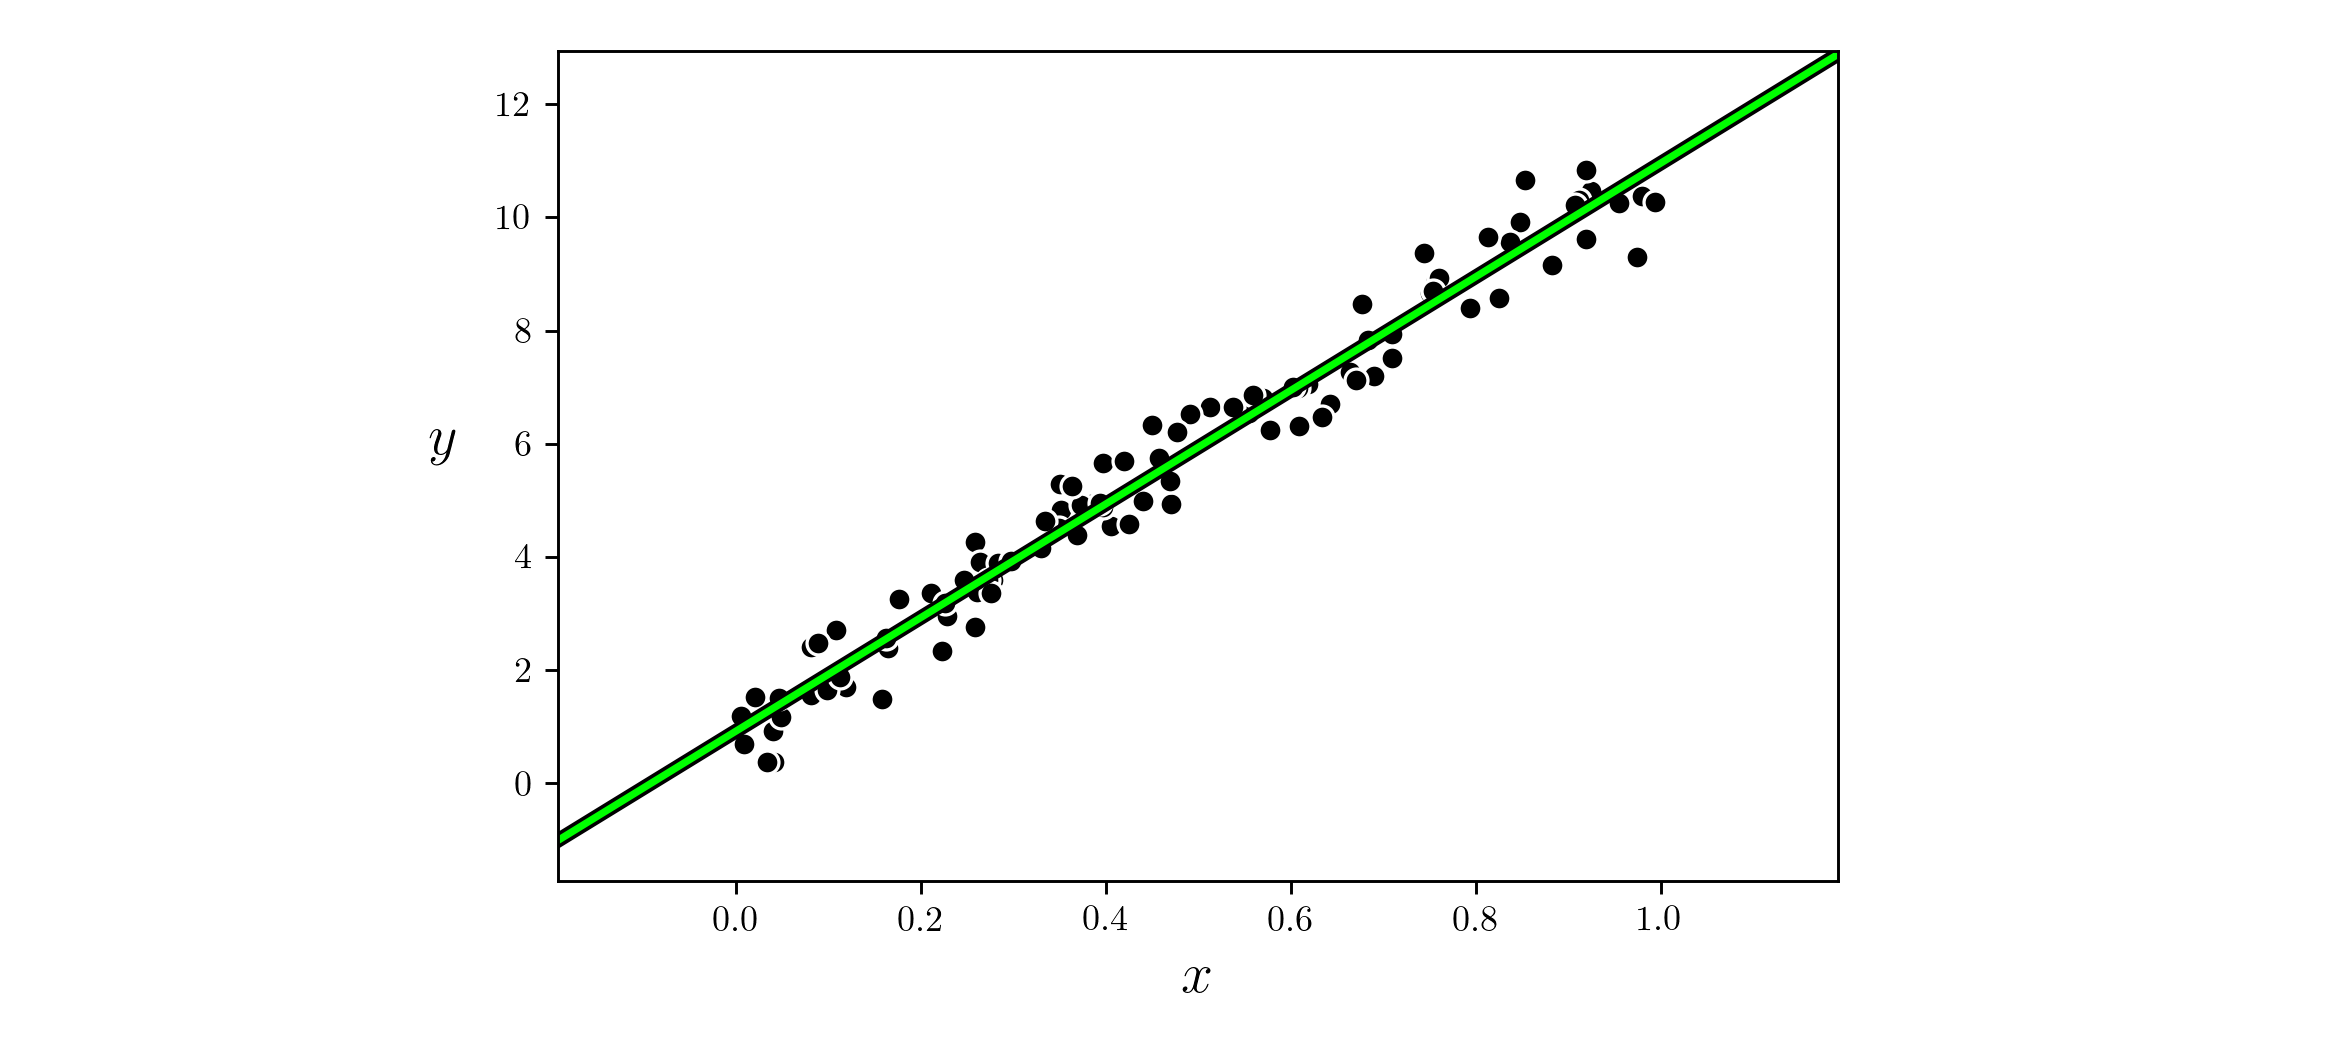

In [6]:
## This code cell will not be shown in the HTML version of this notebook
# parameters for our two runs of gradient descent
w = 0.1*np.random.randn(2,1); max_its = 500; alpha_choice = 10**(-1)

# the trivial linear feature transformation
def feature_transforms(x):
    return x

# run on normalized data
run = nonlib.basic_runner.Setup(x,y,feature_transforms,'least_squares',normalize = 'standard')
run.fit(w=w,alpha_choice = alpha_choice,max_its = max_its)

# pluck out best weights - those that provided lowest cost, 
# and plot resulting fit
ind = np.argmin(run.cost_history)
w_best = run.weight_history[ind]
demo.plot_fit(w_best,run.model,normalizer = run.normalizer);

#### <span style="color:#a50e3e;">Example 2. </span> Modeling a familiar wave using a parameterized feature transformation

<IPython.core.display.Javascript object>


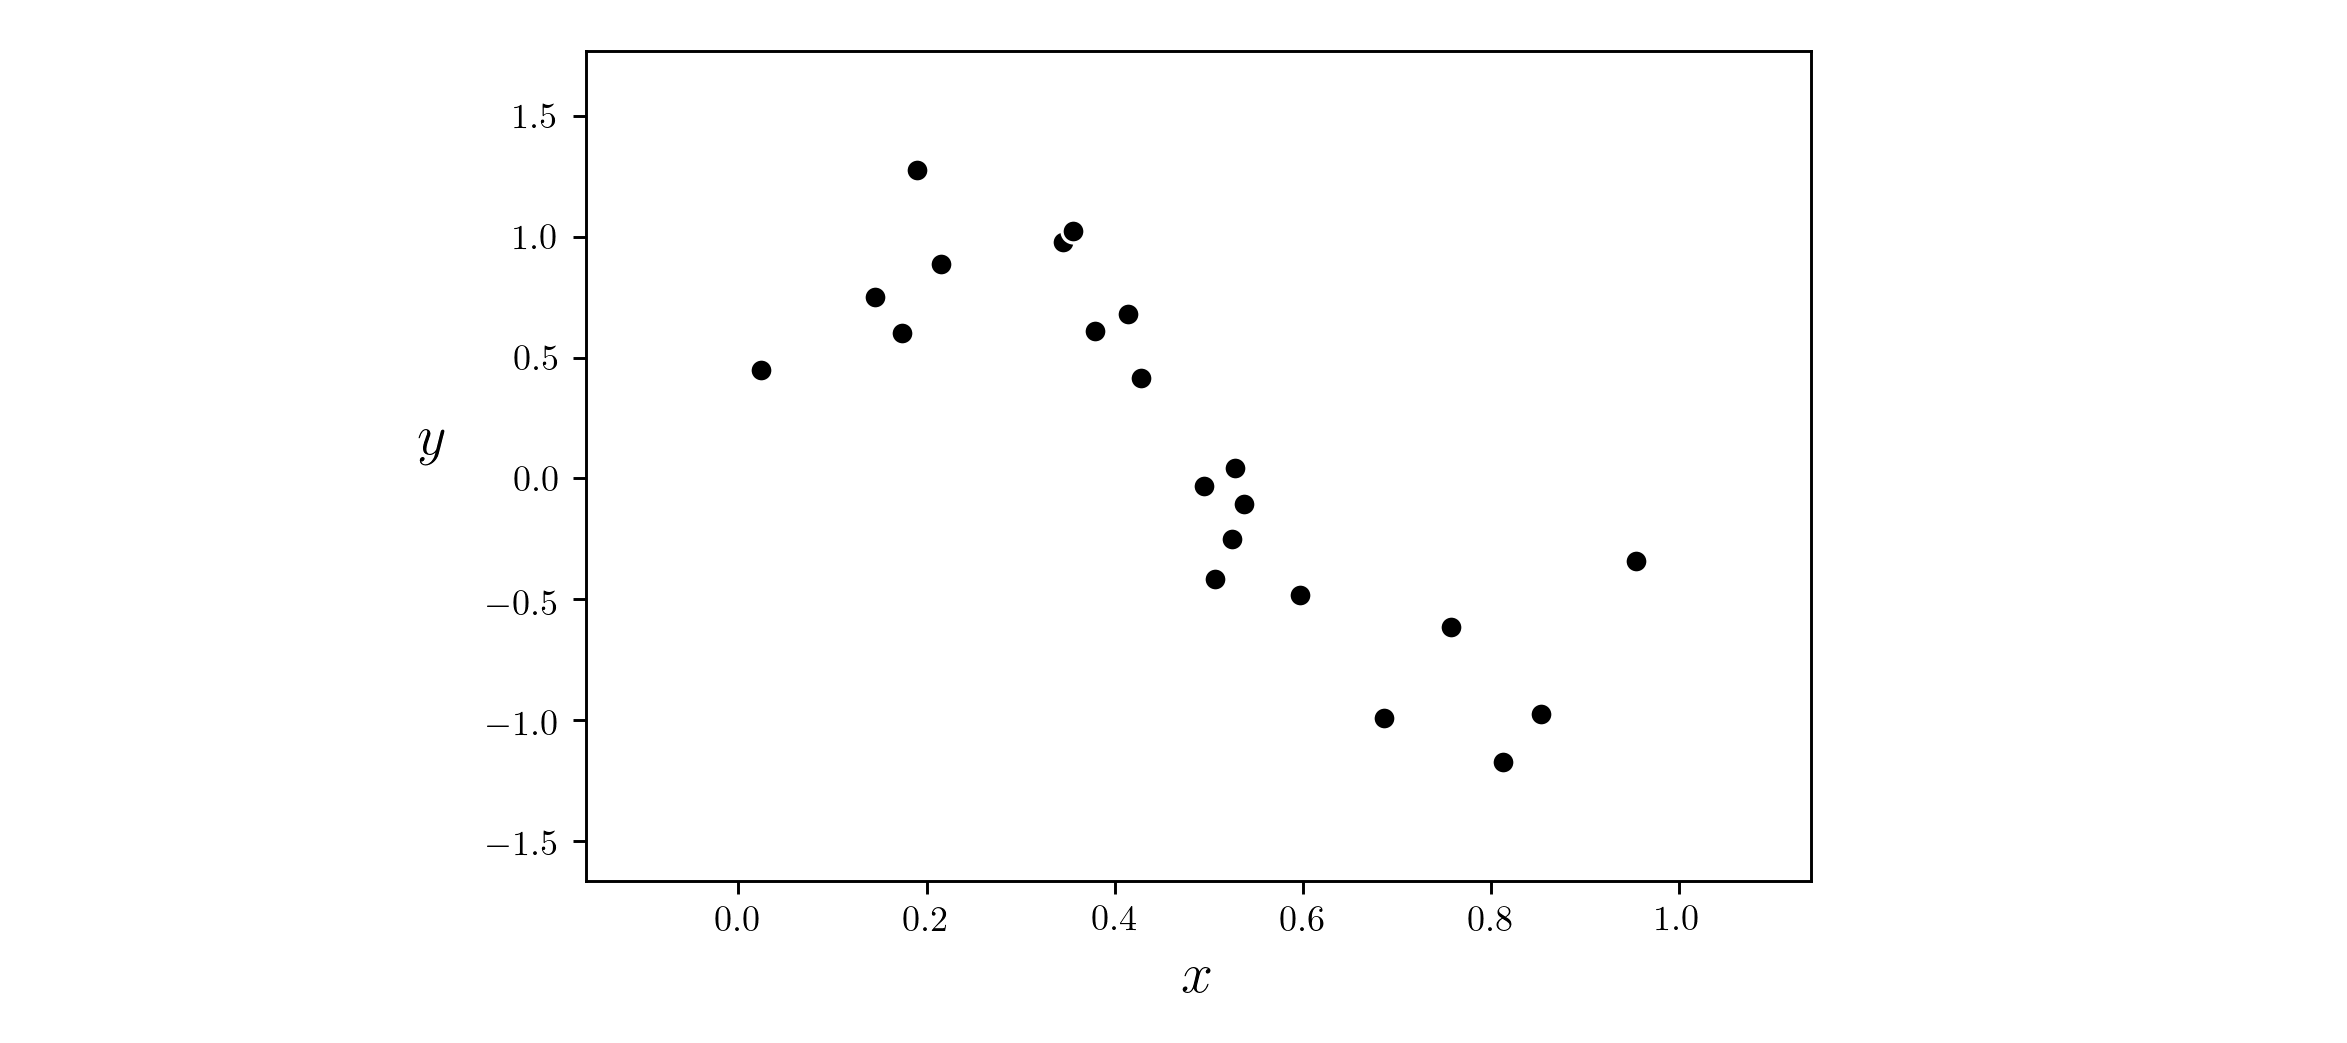

In [7]:
## This code cell will not be shown in the HTML version of this notebook
# load data
csvname = datapath + 'noisy_sin_sample.csv'
data = np.loadtxt(csvname,delimiter = ',')

# load input/output data
x = data[:-1,:]
y = data[-1:,:] 

# plot dataset
demo = regress_plotter.Visualizer(data)
demo.plot_data()

 This dataset looks sinusoidal, so we can defensibly propose a `model` consisting of completely *parameterized* sinusoidal function or *feature transformation* 

\begin{equation}
f\left(x,\mathbf{w}\right) = \text{sin}\left(w_0 + xw_1\right).
\end{equation}

We can then take as our model a linear combination of this nonlinear feature transformation as

\begin{equation}
\text{model}\left(x,\Omega\right) = w_2 + f\left(x,\mathbf{w}\right)w_{3\,}.
\end{equation}

This seems like it could fit the data well if its parameters were all tuned properly via e.g., minimizing the associated Least Squares cost.  Tuning these parameters via gradient descent we can produce the following fit to our original data employing the nonlinear model above, which fits quite well.

<IPython.core.display.Javascript object>


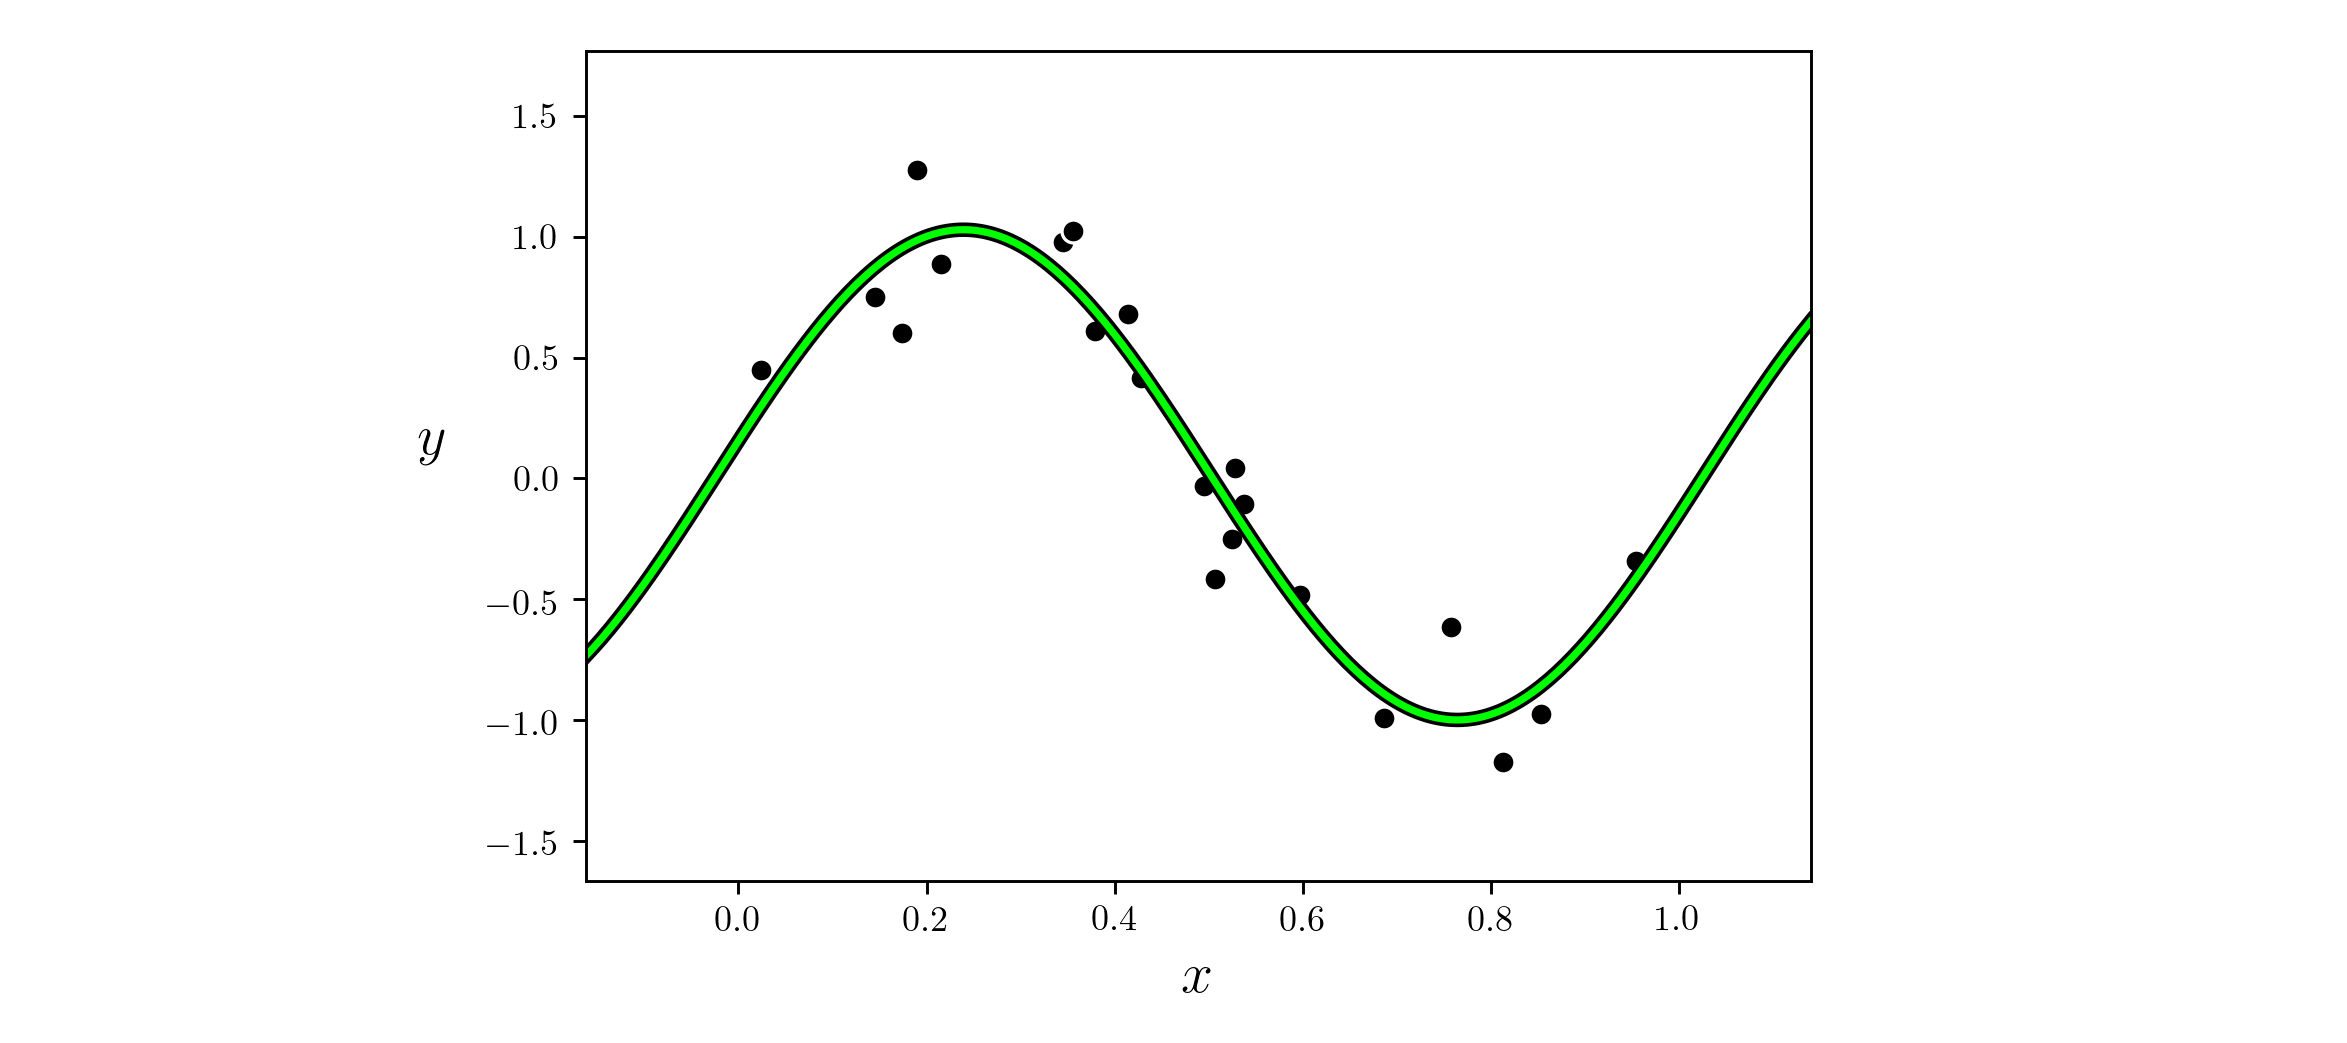

In [9]:
## This code cell will not be shown in the HTML version of this notebook
# the feature transformation from Example 2 
def feature_transforms(x,w):
    # calculate feature transform
    f = np.sin(w[0] + np.dot(x.T,w[1:])).T
    return f

# parameters for our two runs of gradient descent
w = np.array([0.1*np.random.randn(2,1),0.1*np.random.randn(2,1)])
max_its = 500; alpha_choice = 10**(-1)

# run on original data
run1 = nonlib.basic_runner.Setup(x,y,feature_transforms,'least_squares',normalize = 'None')
run1.fit(w=w,alpha_choice = alpha_choice,max_its=max_its)

# run on normalized data
run2 = nonlib.basic_runner.Setup(x,y,feature_transforms,'least_squares',normalize = 'standard')
run2.fit(w=w,alpha_choice = alpha_choice,max_its=max_its)

# pluck out best weights - those that provided lowest cost, 
# and plot resulting fit
ind = np.argmin(run2.cost_history)
w_best = run2.weight_history[ind]
demo.plot_fit(w_best,run2.model,normalizer = run2.normalizer);

With our weights fully tuned notice that  since `model` is defined *linearly* in terms of its feature transformation we can represent our transformed input $x_p \longleftarrow f\left(x_p,\mathbf{w}^{\star}\right)$ and the correspnoding model fit $
\text{model}\left(x,\Omega^{\star}\right)$ in what is called the *transformed feature space*.  This is simply the space whose input is the feature transformed input $\,f\left(x_p,\mathbf{w}^{\star}\right)$ and whose output remains as $y$.  In this space our *nonlinear* fit is a *linear* one.  In other words, with our model completely tuned if plot the points $\left(f\left(x_1,\mathbf{w}^{\star}\right),y_1\right),\,\left(f\left(x_2,\mathbf{w}^{\star}\right),y_2\right)...,\left(f\left(x_P,\mathbf{w}^{\star}\right),y_P\right)$ - as we do below in the right panel - our model fits the transformed data *linearly*.

This finding is true in general with nonlinear regression problems.

> A properly designed feature (or set of features) provides a good nonlinear fit in the original feature space and, simultaneously, a good linear fit in the transformed feature space.

<IPython.core.display.Javascript object>


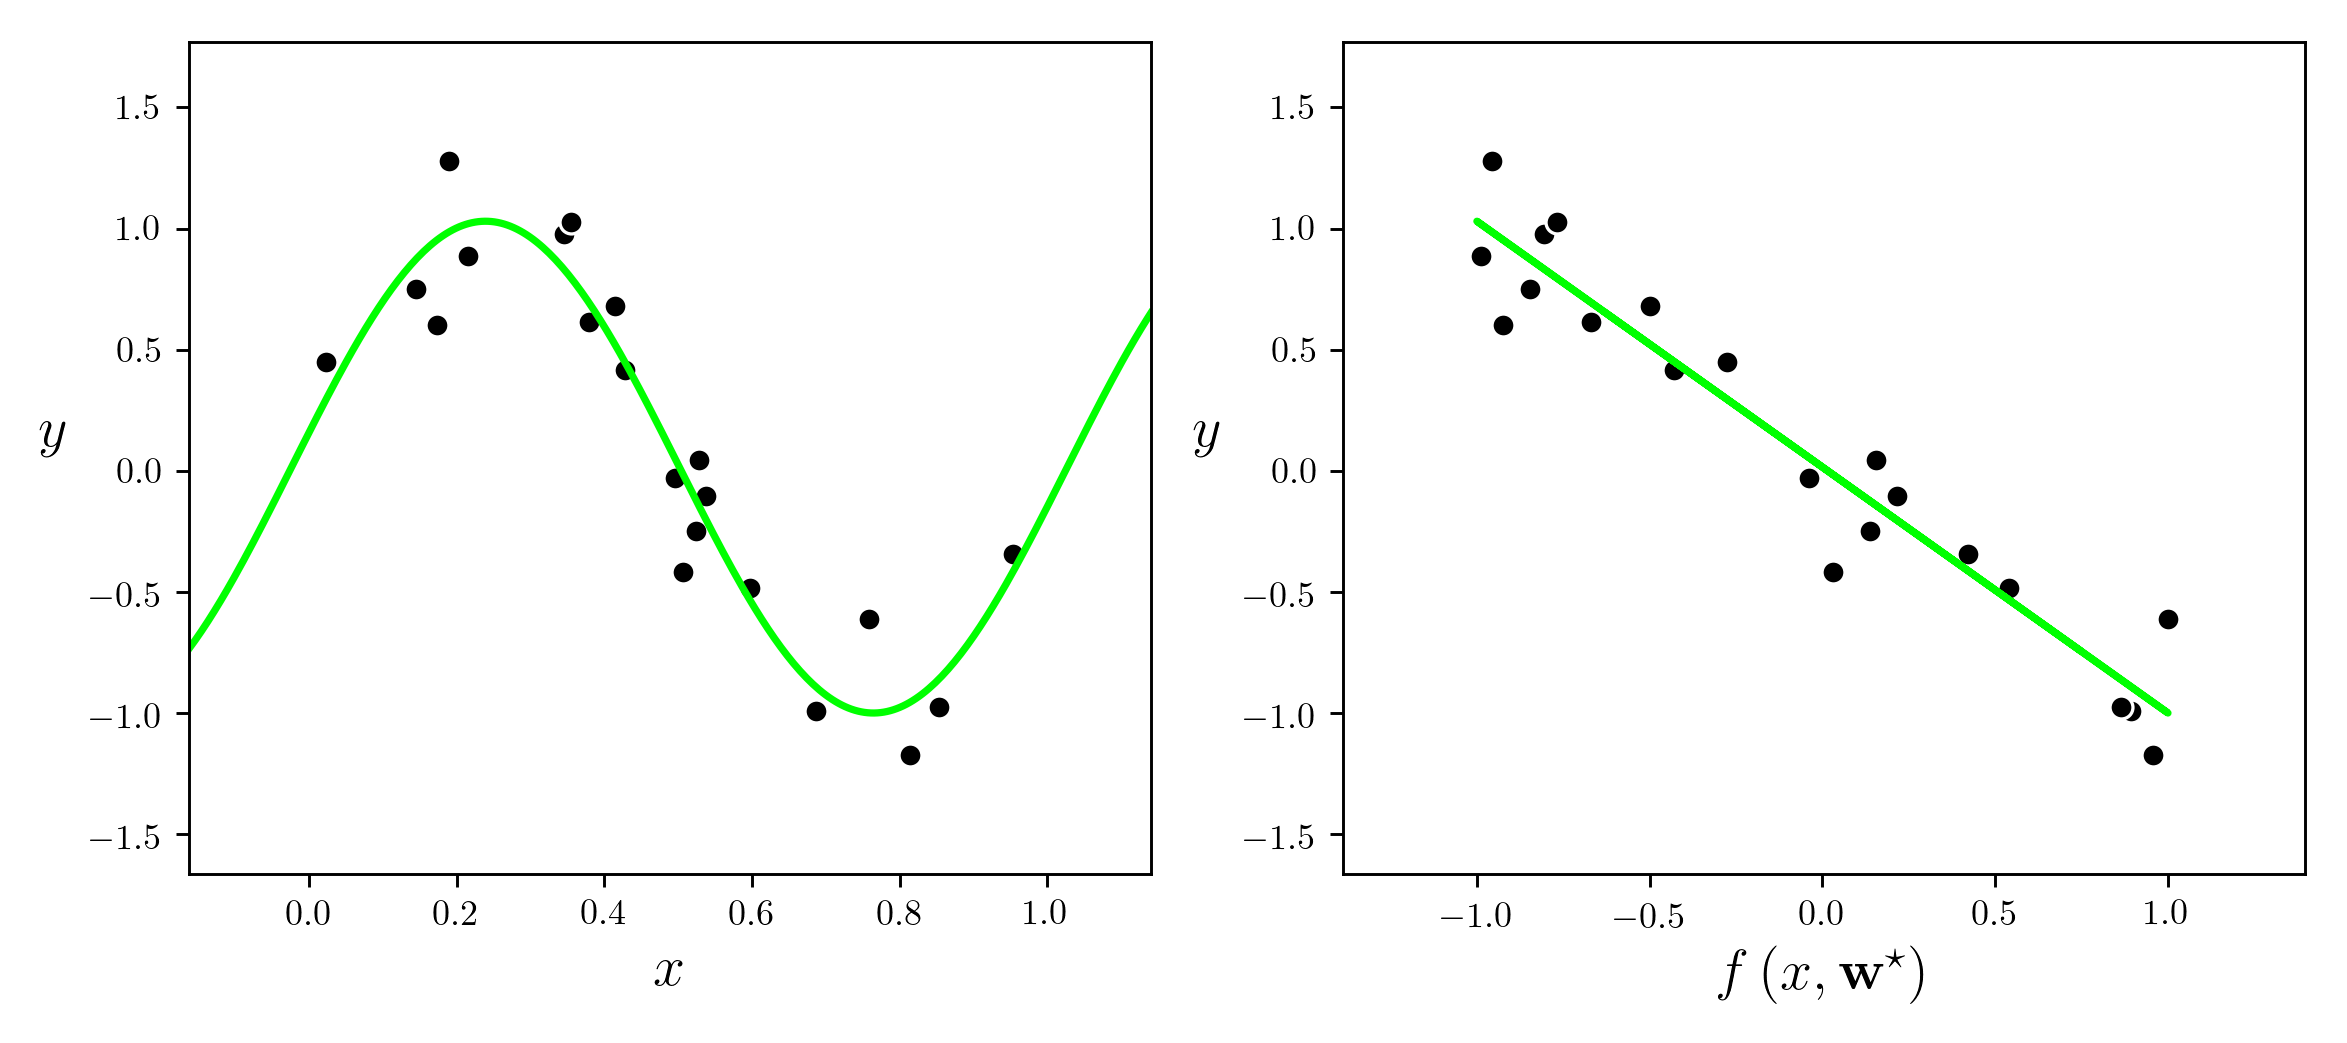

In [29]:
## This code cell will not be shown in the HTML version of this notebook
# plot data and fit in original and feature transformed space
demo.plot_fit_and_feature_space(w_best,run2.model,run2.feature_transforms,normalizer = run2.normalizer)

Finally note, as with the previous example that we can - and should - employ standard normalization to scale our input here when employing gradient descent to minimize the corresponding Least Squares cost.   *Feature scaling* - discussed in the context of *linear* regression in Sections 9.2 - 9.3 - is equally important in the context of nonlinear regression.  Here it also helps temper the contours of any regression cost function making it considerably easier for gradient descent to minimize.  Below we show the resulting cost function history resulting from a run of gradient descent employing the original and standard normalized versions of the input.  Comparing the two plots we can see that a significantly lower cost function value was found using the standard-normalized input.  Moreover, the convergence behavior displayed by the cost function plot on the original data is actually somewhat deceiving here - it appears to converge but not to a global minimum.

<IPython.core.display.Javascript object>


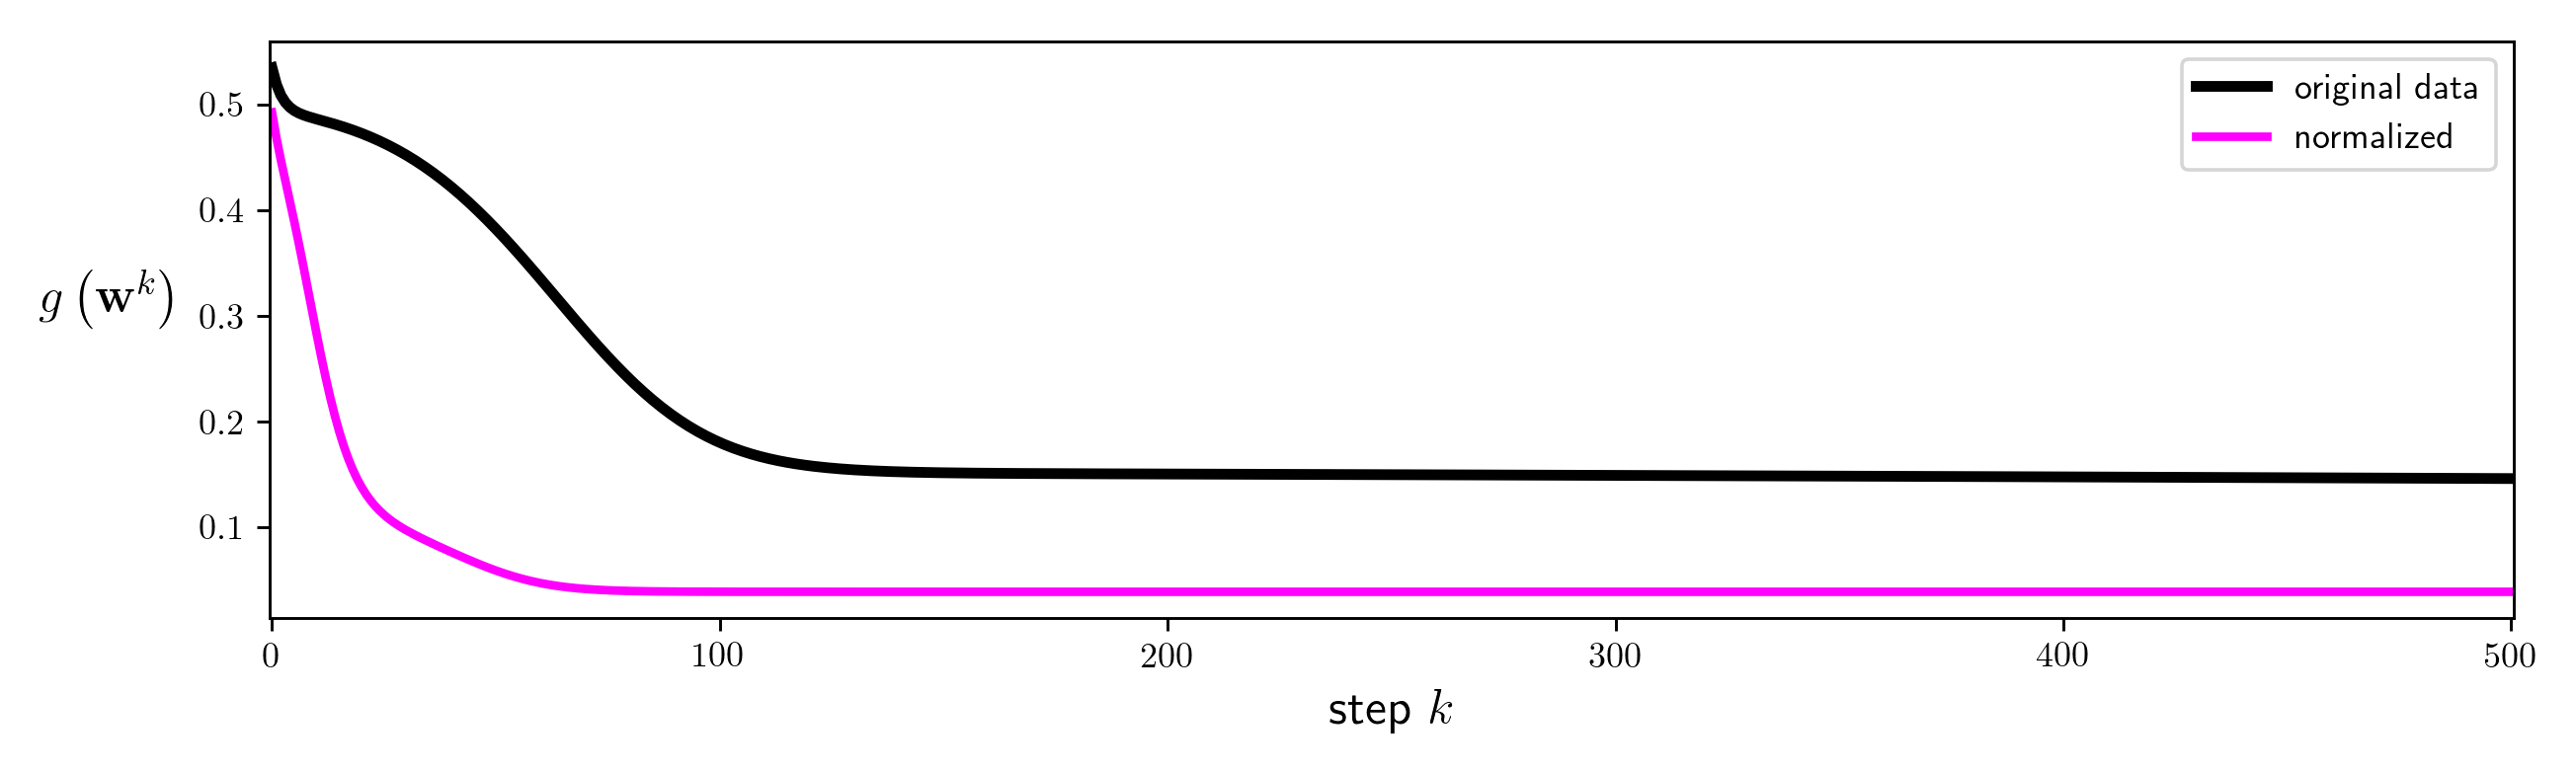

In [27]:
## This code cell will not be shown in the HTML version of this notebook
# plot the cost function history for a given run
static_plotter.plot_cost_histories([run1.cost_history,run2.cost_history],start = 0,points = False,labels = ['original data','normalized'])

#### <span style="color:#a50e3e;">Example 3. </span> Modeling population growth using a parameterized feature transformation

Next we examine a population growth dataset - which shows the population of Yeast cells growing in a constrained chamber (you can find the [source of this dataset here](http://math.arizona.edu/~dsl/byeast.htm)).  This is a common shape found with population growth data, where the creature under study starts off with only a few members and is only limited in growth by how fast it can reproduce and the resources available in its environment.  In the beginning such a population grows exponentially.  This growth halts rapidly when the population reaches the maximum carrying capacity of its environment.

<IPython.core.display.Javascript object>


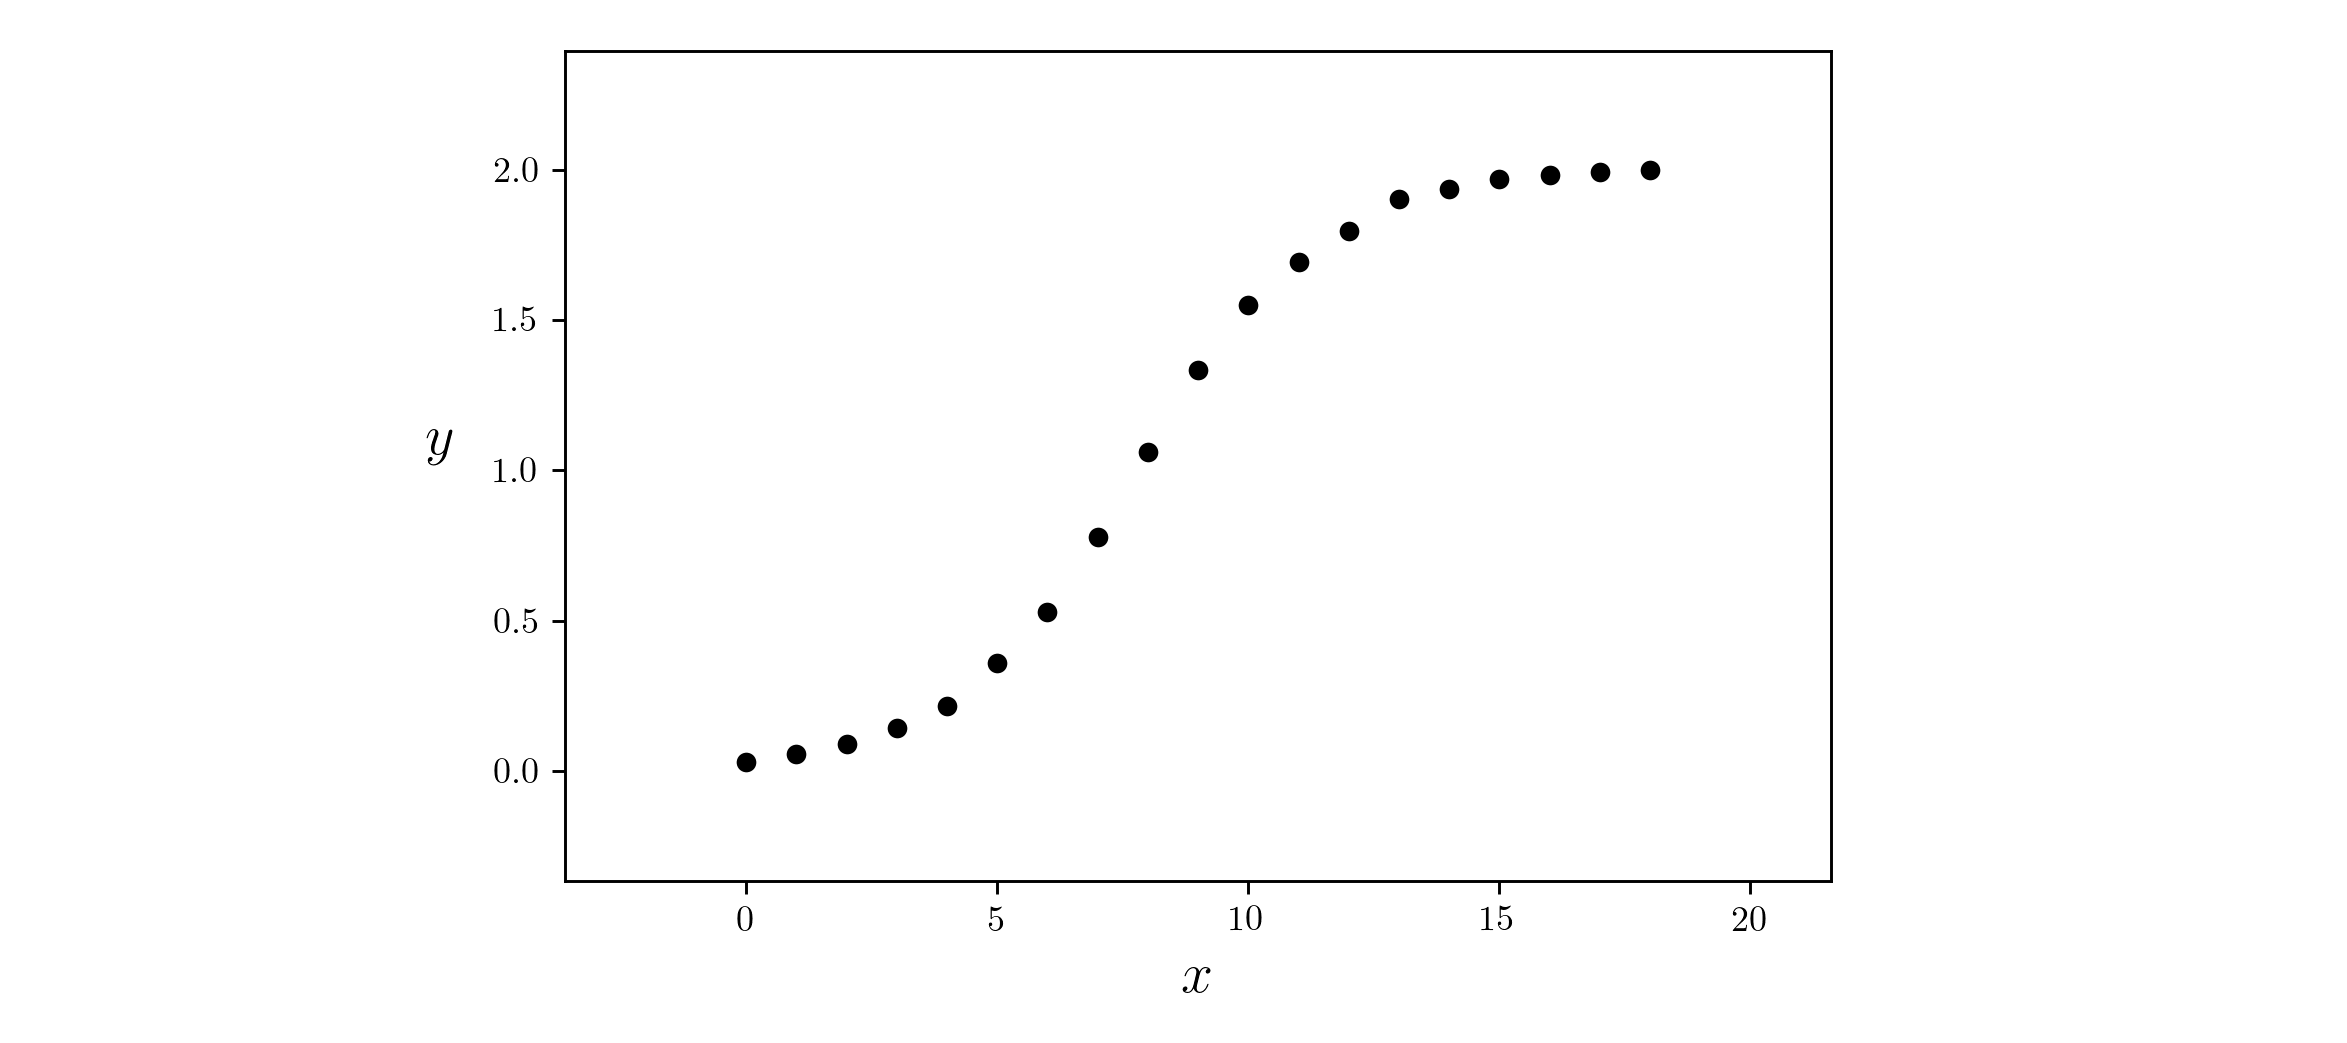

In [30]:
## This code cell will not be shown in the HTML version of this notebook
# load data
csvname = datapath + 'yeast.csv'
data = np.loadtxt(csvname,delimiter = ',')

# get input/output pairs
x = data[:-1,:]
y = data[-1:,:] 

# plot dataset
demo = regress_plotter.Visualizer(data)
demo.plot_data()

If we take a moment and visually examine this dataset, it appears that some sort of logistic sigmoid / hyperbolic tangent nonlinearity would fit it quite well.  So using a *parameterized* tanh feature transformation 

\begin{equation}
f\left(x,\mathbf{w}\right) = \text{tanh}\left(w_0 + xw_1\right).
\end{equation}

we can then take as our model a linear combination of this nonlinear feature transformation as

\begin{equation}
\text{model}\left(x,\Omega\right) = w_2 + f\left(x,\mathbf{w}\right)w_{3\,}.
\end{equation}

Note here we that our parameter set $\Omega$ contains all weights present in the respective formula - that is $w_0 $ through $w_3$.

We then tune the pararmeters of this nonlinear model on the standard-normalized input and the Least Squares cost using gradient descent,  and then fit our model in both the original space (where it provides a good nonlinear fit) as well as in the *transformed feature space* where it simultaneously provides a good linear fit to the transformed data (as discussed in the previous example).

<IPython.core.display.Javascript object>


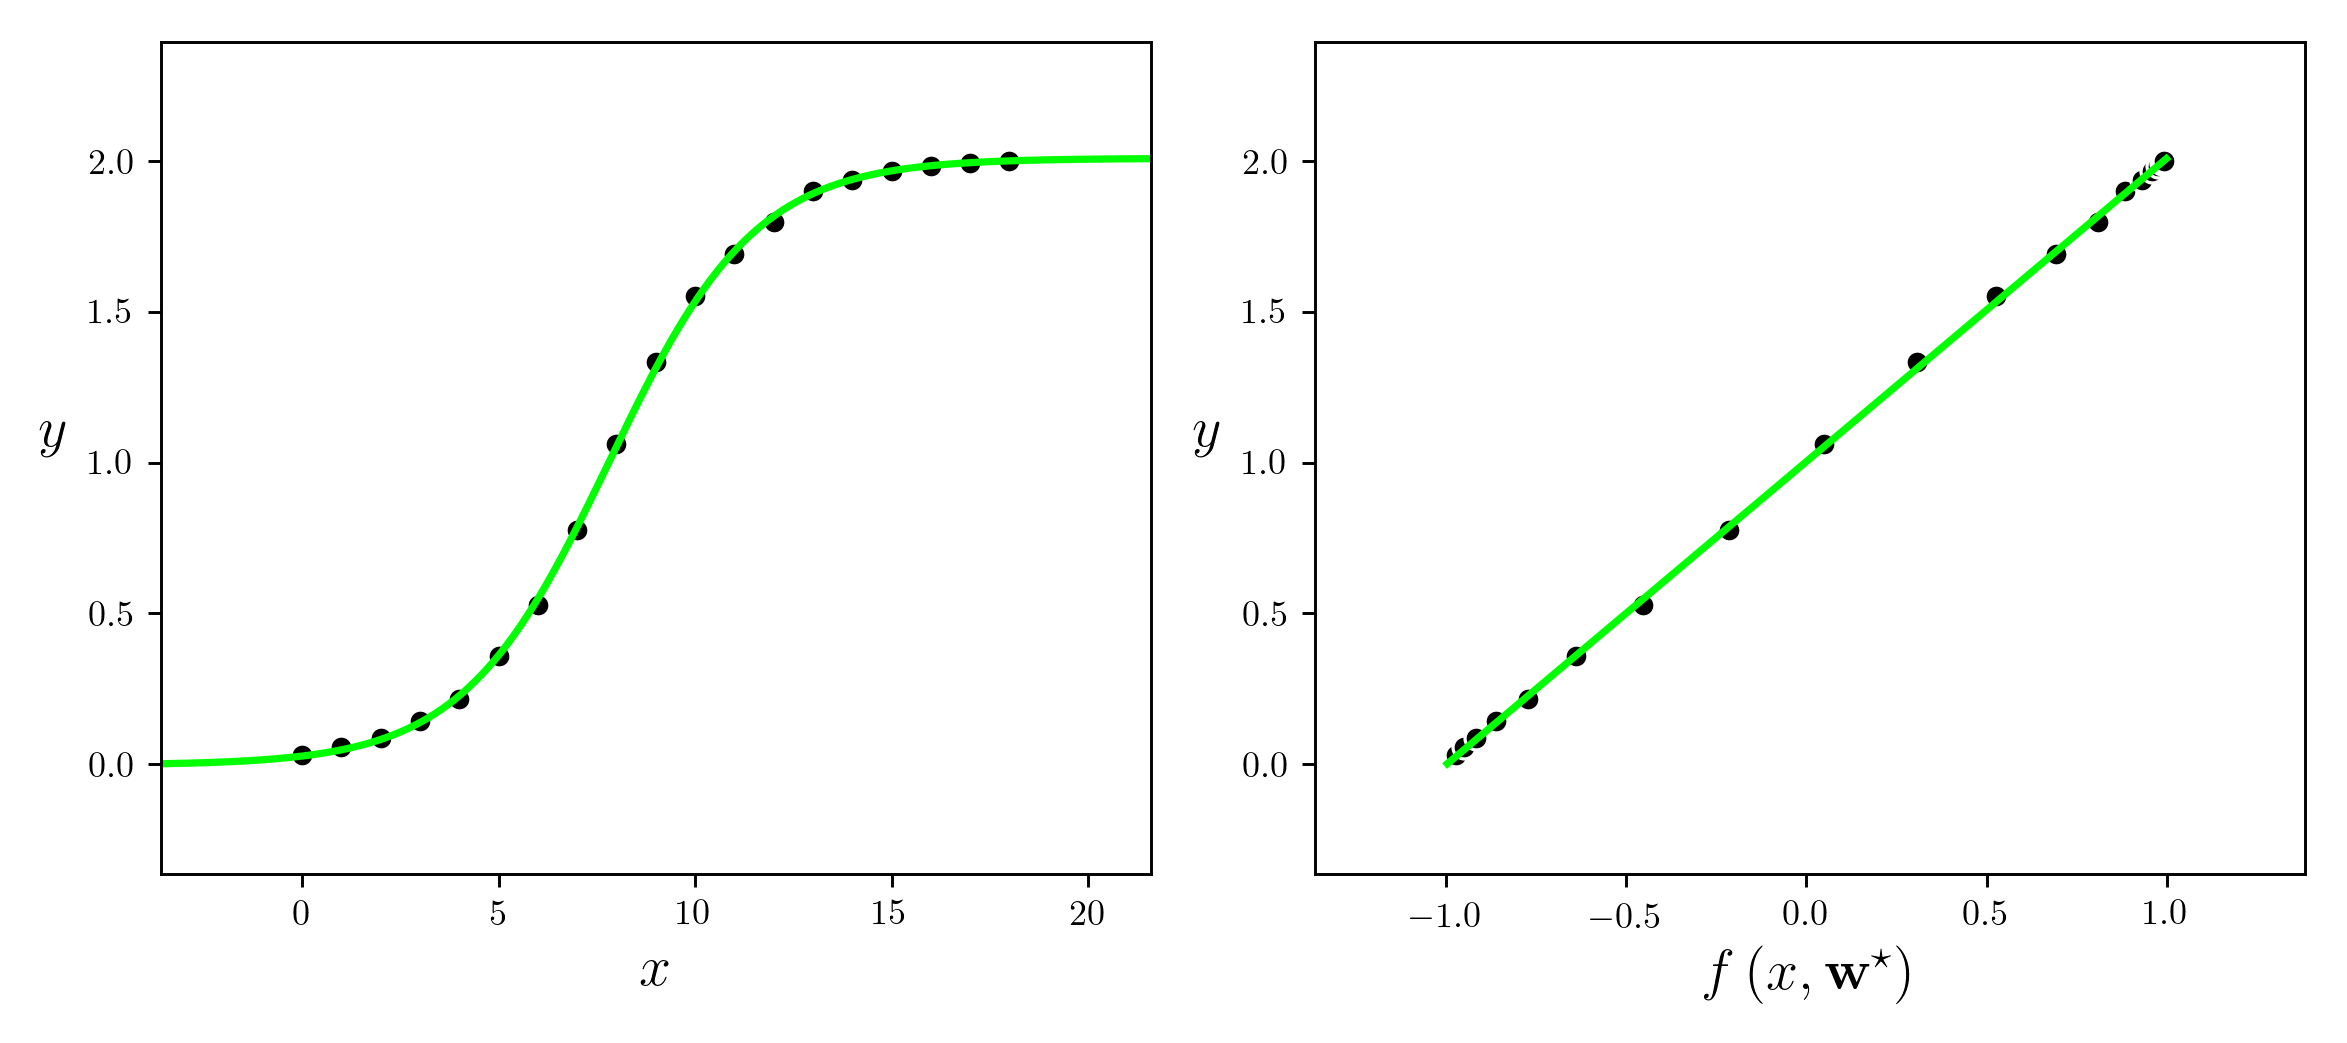

In [34]:
## This code cell will not be shown in the HTML version of this notebook
# parameters for our two runs of gradient descent
w = np.array([0.1*np.random.randn(2,1),0.1*np.random.randn(2,1)])
max_its = 1000; alpha_choice = 10**(-1);

# our nonlinearity, known as a feature transformation
def feature_transforms(x,w):
    # calculate feature transform
    f = np.tanh(w[0] + np.dot(x.T,w[1:])).T
    return f

# run on original data
run1 = nonlib.basic_runner.Setup(x,y,feature_transforms,'least_squares',normalize = 'standard')
run1.fit(w=w,alpha_choice = alpha_choice,max_its=max_its)

# plot the cost function history for a given run
static_plotter.plot_cost_histories([run1.cost_history],start = 0,points = False,labels = ['normalized'])

# plot data and fit in original and feature transformed space
ind = np.argmin(run1.cost_history)
w_best = run1.weight_history[ind]
demo.plot_fit_and_feature_space(w_best,run1.model,run1.feature_transforms,normalizer = run1.normalizer)

#### <span style="color:#a50e3e;">Example 4. </span> Using an unparameterized feature transformation to model a classic physics dataset

In 1638 Galileo Galilei, infamous for his expulsion from the Catholic church for daring to claim that the earth orbited the sun and not the converse (as was the prevailing belief at the time) published his final book: [Discourses and Mathematical Demonstrations Relating to Two New Sciences](https://books.google.com/books?hl=en&lr=&id=8BhZAAAAYAAJ&oi=fnd&pg=PA11&ots=5pQfKe7Bby&sig=VVWwm0GtVvS9YnydNJXHU_UxBjA#v=onepage&q&f=false). In this book, written as a discourse among three men in the tradition of Aristotle, he described his experimental and philosophical evidence for the notion of uniformly accelerated physical motion. Specifically, Galileo (and others) had intuition that the acceleration of an object due to (the force we now know as) gravity is uniform in time, or in other words that the distance an object falls is directly proportional (i.e., linearly related) to the amount of time it has been traveling, squared. This relationship was empirically solidified using the following ingeniously simple experiment performed by Galileo.

Repeatedly rolling a metal ball down a grooved $\frac{1}{2}$ meter long piece of wood set at an incline as shown in the Figure below, Galileo timed how long the ball took to get $\frac{1}{4}$,$\frac{1}{2}$, $\frac{2}{3}$, $\frac{3}{4}$, and all the way down the wood ramp. 

<p>
<figure>
  <img src= '../../mlrefined_images/nonlinear_superlearn_images/Fig_1_12.png' width="80%" height="60%" alt=""/>
  <figcaption>   
<strong>Figure 5:</strong> <em> Figurative illustration of
Galileo's ramp experiment setup used for exploring the relationship
between time and the distance an object falls due to gravity. To perform
this experiment he repeatedly rolled a ball down a ramp and timed
how long it took to get $\frac{1}{4}$,$\frac{1}{2}$, $\frac{2}{3}$,
$\frac{3}{4}$, and all the way down the ramp.  </em>  </figcaption> 
</figure>
</p>

 Why didn't Galileo simply drop the ball from some height and time how long it took to reach certain distances to the ground?  Because no reliable way to measure time yet existed (he had to use a [water clock](https://en.wikipedia.org/wiki/Water_clock) for these experiments)!   Galileo was the one who set humanity on the route towards its first reliable time-piece in his studies of the [pendulum](http://galileo.rice.edu/sci/instruments/pendulum.html)
 
Data from a ([modern reenactment](Straulino, S, "Reconstruction of Galileo Galilei's experiment: the inclined plane", Physics Education 43, 3 2008, pp. 316.)) of these experiments (averaged over 30 trials), results in the 6 data points shown below.  Here the input axis is the number seconds while the output is the portion of the ramp traveled by the ball during the experiments.

<IPython.core.display.Javascript object>


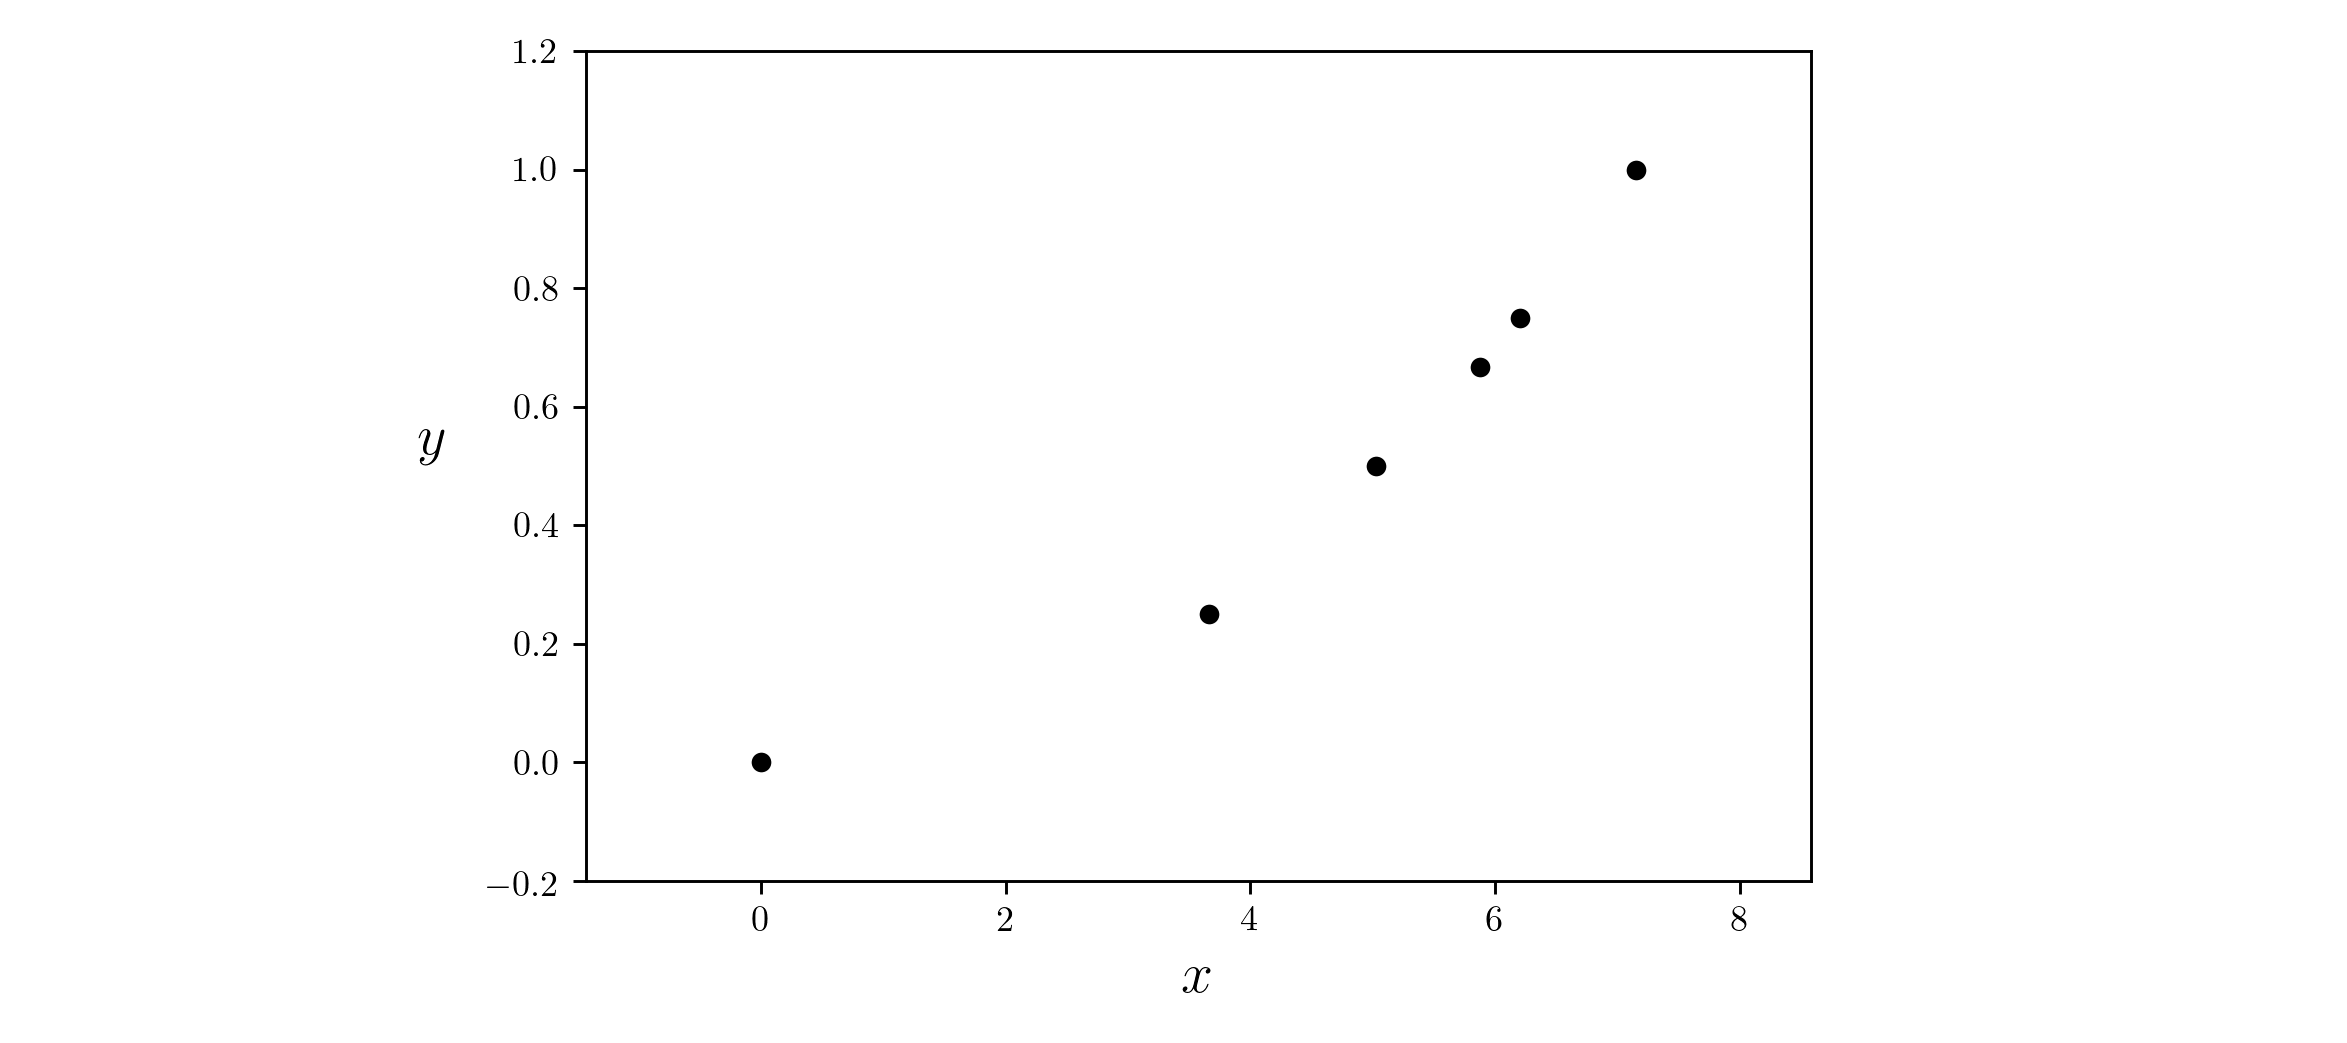

In [35]:
## This code cell will not be shown in the HTML version of this notebook
# load data
csvname = datapath + 'galileo_ramp_data.csv'
data = np.loadtxt(csvname,delimiter = ',')

# get input/output pairs
x = data[:-1,:]
y = data[-1:,:] 

# plot dataset
demo = regress_plotter.Visualizer(data)
demo.plot_data()

The data here certainly displays a nonlinear relationship and by viewing it - and using his physical intuition Galileo - intuited a *quadratic* relationship.  Or in our jargon that for some $w_0$, $w_1$, and $w_2$ the modeling function 

\begin{equation}
\text{model}(x,\Omega) = w_0 + xw_1 + x^2w_2
\end{equation}

provides the correct sort of nonlinearity to explain this data (albeit when the parameters are tuned correctly).  

Notice here how we have two *unparameterized* feature transformations: the identity $f_1(x) = x$ and the quadratic term $f_2(x) = x^2$, and so we may write the above equivalently as

\begin{equation}
\text{model}(x,\Omega) = w_0 + f_1(x)\,w_1 + f_2(x)\,w_2
\end{equation}

which clearly shows how we are seeking out a proper linear relationship in the transformed feature space (which in this case is two-dimensional).  Note here - unlike the previous examples - neither of these feature transformations are *fixed* in that they take in no internal weights.

After standard-normalizing the input of this dataset we minimize the Least Squares cost via gradient descent, and plot the corresponding best nonlinear fit on the original data (left panel below) as well as corresponding linear fit on the feature transformed data (right panel below).  Notice that since we have two features in this instance our linear fit is in a space one dimension higher than the original input space defined by $x$.  In other words, the transformed feature space here has *two* inputs: one defined by each of the two features $f_1$ and $f_2$.

<IPython.core.display.Javascript object>


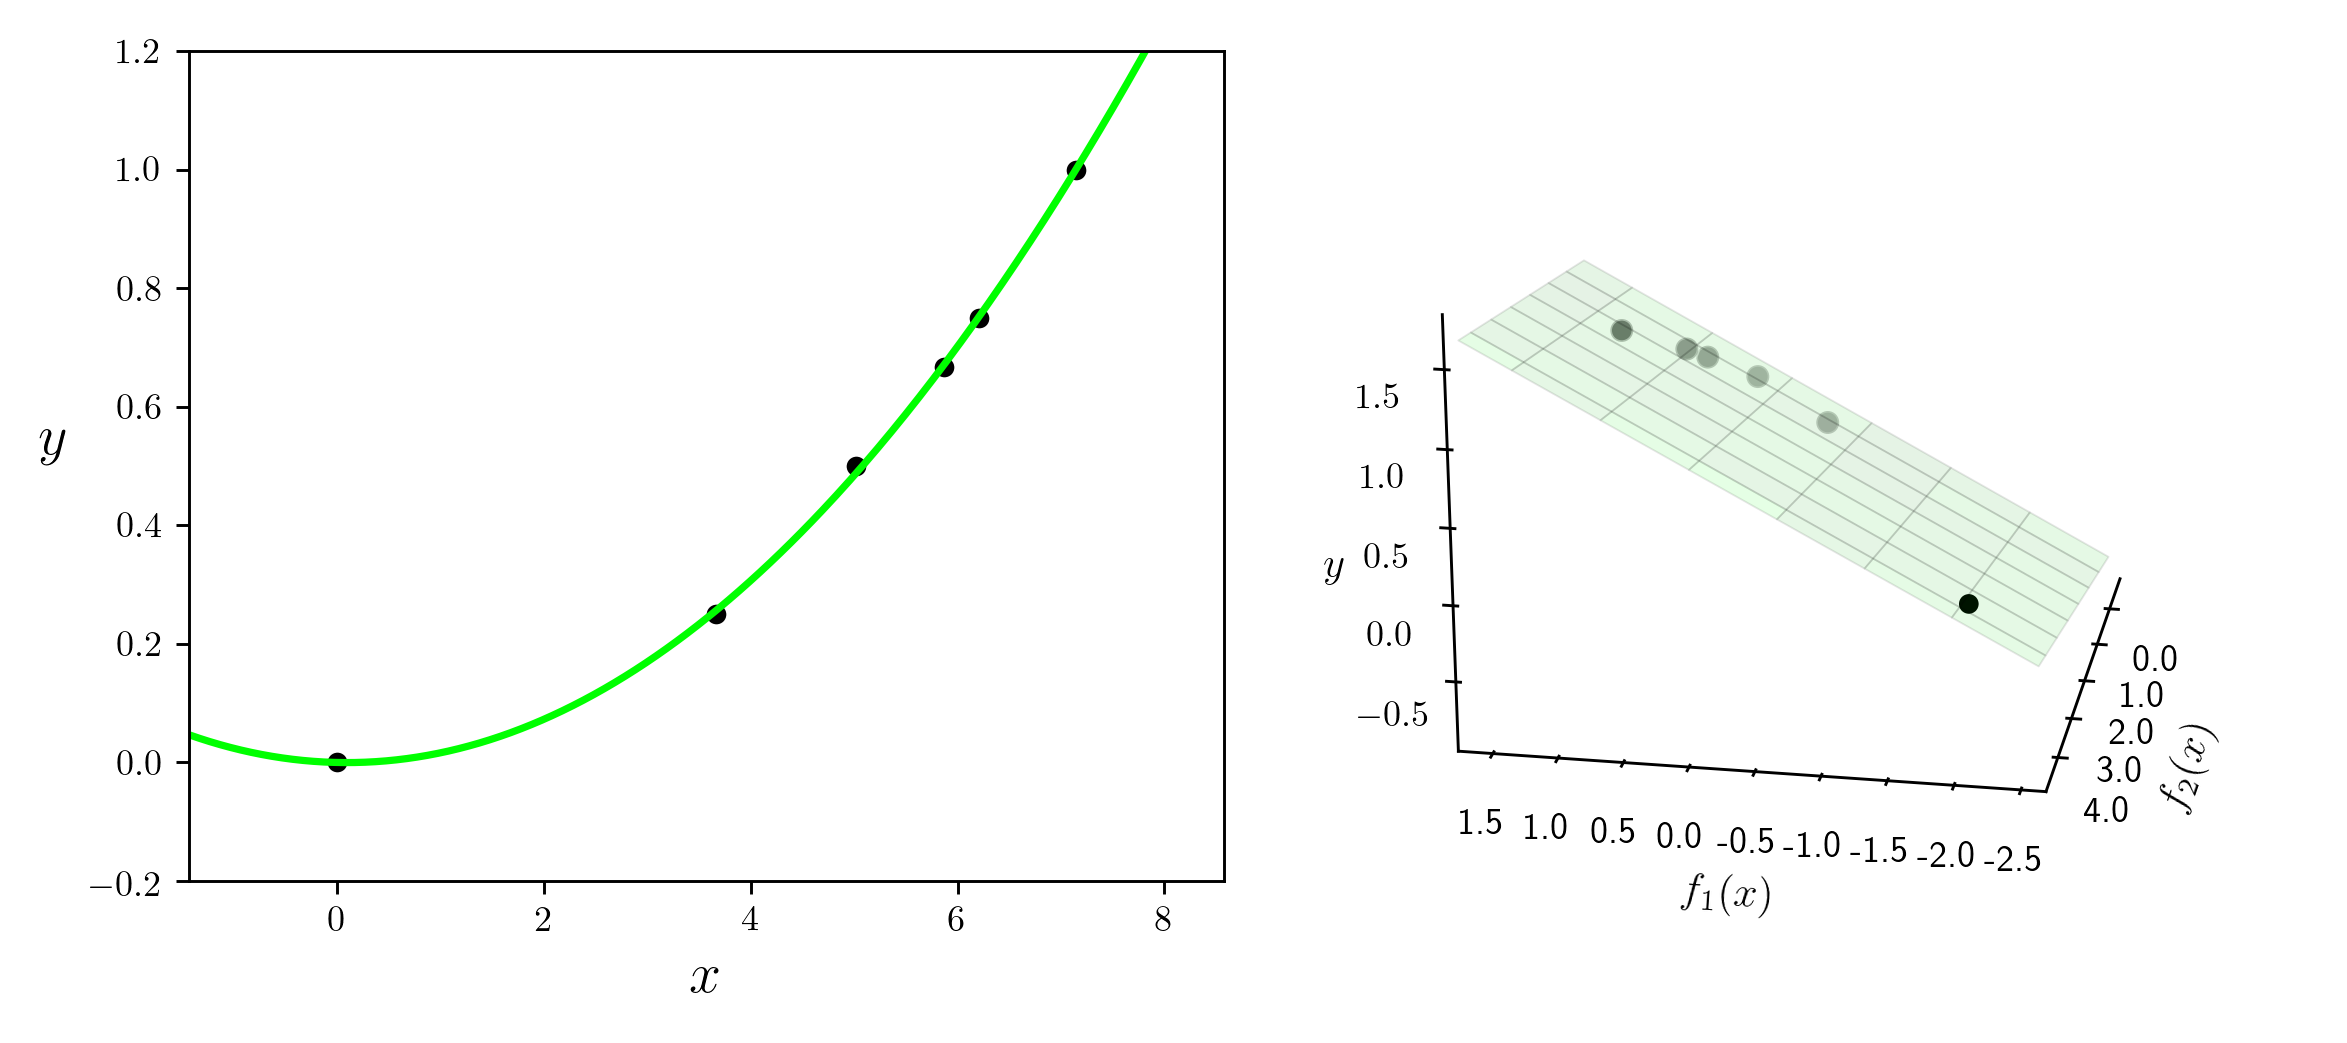

In [38]:
## This code cell will not be shown in the HTML version of this notebook
# parameters for our two runs of gradient descent
w = 0.1*np.random.randn(3,1);
max_its = 50; alpha_choice = 10**(-1);

# feature transform 
def feature_transforms(x):
    # calculate feature transform
    f = np.array([(x.flatten()**d) for d in range(1,3)])   
    return f

# run on original data
run1 = nonlib.basic_runner.Setup(x,y,feature_transforms,'least_squares',normalize = 'standard')
run1.fit(w=w,alpha_choice = alpha_choice,max_its=max_its)

# plot data and fit in original and feature transformed space
ind = np.argmin(run1.cost_history)
w_best = run1.weight_history[ind]
demo.plot_fit_and_feature_space(w_best,run1.model,run1.feature_transforms,normalizer = run1.normalizer,view = [25,100])

Notice that trend is true more generally speaking: the more feature transforms we use the higher the up we go in terms of the dimensions of our transformed feature space / linear fit!  In general if our original input has dimension $N$ - and is written as $\mathbf{x}$ - and we use a `model` function that employs $B$ nonlinear feature transformations as

\begin{equation}
\text{model}\left(\mathbf{x},\Omega\right) = w_0 + f_1\left(\mathbf{x}\right){w}_{1} +  f_2\left(\mathbf{x}\right){w}_{2} + \cdots + f_B\left(\mathbf{x}\right)w_B
\end{equation}

then our original space has $N$ dimensional input, while our transformed feature space is $B$ dimensional.  Note here that the set of all weights $\omega$ contains not only the weights $w_1,\,w_2,...,w_B$ from the linear combination, but also any features's internal parameters as well.

## 10.1.2 Implementing nonlinear regression in `Python`

Below we show a universal way to implement the generic nonlinear model shown in equation (4) above, generalizing our original linear implementation (see e.g., Section 5.1.3). 

In [ ]:
# an implementation of our model employing a nonlinear feature transformation
def model(x,w):    
    # feature transformation 
    f = feature_transforms(x,w[0])
    
    # compute linear combination and return
    a = w[1][0] + np.dot(f.T,w[1][1:])
    return a.T

Here our generic set of engineered feature transformations are implemented in the `Python` function `feature_transforms`.  Here we have implemented this function as generically as possible, to encompass the case where our desired feature transformations have internal parameters.  Here we package the model weights in the set $\Omega$ as `w`, which is a list containing the *internal weights* of  `feature_transforms` in its first entry `w[0]`, and the weights in the final linear combination of the model stored in second etnry `w[1]`).  e.g., the `feature_transforms` function employed in Example 2 above can be implemented as follows

In [ ]:
# the feature transformation from Example 2 
def feature_transforms(x,w):
    # calculate feature transform
    f = np.sin(w[0] + np.dot(x.T,w[1:])).T
    return f


If our desired feature transformations do not have internal parameters we can either leave the parameter input to this function empty, or implement the model above slightly differently by computing our set of feature transformations as


                                f = feature_transforms(x)
                        
                        
and computing the linear combination of these transformed features in line 7 as


                                a = w[0] + np.dot(f.T,w[1:])

In either case, in order to successfully perform nonlinear regression we can focus our attention solely on implementing the function `feature_transforms` - employing the `autograd`'-wrapped `numpy` library if we wish to employ automatic differentiation (see Section 3.4).  Since only our implemented `model` needs adjusting, nothing about how we implement our *regression cost functions* changes from the originnal context of linear regression detailed in Chapter 5.  In other words, once we have implemented a given set of feature transformations correctly, employing the `model` above we can then tune the parameters of our nonlinear regression precisely as we have done in Chapter 5 employing any regression cost function and local optimization scheme.

&copy; This material is not to be distributed, copied, or reused without written permission from the authors.